Figure List: 

Introduction/Motivation

1) Covariance Design 

2) FPR vs. FNR oracle

3) Marginalize over sparsity 

4) FPR vs. FNR BIC vs. R^2

5) Marginalize over sparsity (Effect of model selection)

6) Emerging selection frontier (with results plotted of correlation vs. SNR)

7) MSE coefficient estimation 

8) R2

9) Estimation bias

Future work (information theoretic selection fronteir)


### More specifically, given the three columns, there should be three major themes: 


# Plot of the different covariance designs and the coefficient distributions
 
#### 1) (a)Robustness of selection of different algorithms vs. increasing correlation strength (through a FPR v FNR plot and a margnilized 1D plot) 

#### 2) Importance of model selection criteria (show the difference between BIC and R2)
#### Through 2D plots, highlight the difference in the performance of algorithms using different selection criteria
#### (b) Can have good R^2 and even (total) L2 estimation error even with poor selection
#### (c) Nevertheless, highlight low bias and low variance of UoI estimates on the correctly selected model support

#### (3) Emerging numerical characterization of a selection frontier. Here we need to plot an error probability of partial support recovery across 3 parameters - SNR, average correlation, and the number of samples

In [1]:
# In light of these requirements, we need to put together the 1D and 2D plotters for arbitrary x and y, as well
# as 1 and 2D error probability plots

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# %load ../../loaders/imports.py
import sys, os
import numpy as np
import matplotlib.pyplot as plt
import time
import pdb

# Add the uoicorr directory to the path
sys.path.append('../../../uoicorr_run')

# Add the root directory of this repository
sys.path.append('../..')

from postprocess_utils import *
import pandas as pd
import sqlalchemy

In [4]:
import seaborn as sns

In [5]:
lasso_engine = sqlalchemy.create_engine('sqlite:///lasso.db')
lasso_con = lasso_engine.connect()
mcp_engine = sqlalchemy.create_engine('sqlite:///scad.db')
mcp_con = mcp_engine.connect()
scad_engine = sqlalchemy.create_engine('sqlite:///mcp.db')
scad_con = scad_engine.connect()

uoi_engine = sqlalchemy.create_engine('sqlite:///uoi.db')
uoi_con = uoi_engine.connect()

en_engine = sqlalchemy.create_engine('sqlite:///en.db')
en_con = en_engine.connect()

In [6]:
# These guys are small enough to live in memory
lasso = pd.read_sql_table('pp_df', lasso_con)
mcp = pd.read_sql_table('pp_df', mcp_con)
scad = pd.read_sql_table('pp_df', scad_con)

uoi = pd.read_sql_table('pp_df', uoi_con)
en = pd.read_sql_table('pp_df', en_con)

In [7]:
from plotting_utils import *

In [8]:
sparsity_corr_2D

<function plotting_utils.sparsity_corr_2D(axis, df, z, use_eig_bound=False)>

## FPR vs. FNR plots

In [24]:
kappa = np.unique(lasso['kappa'].values)
sparsity = np.unique(lasso['sparsity'].values)

In [27]:
# Blue
c1 = ['#4286f4', '#99bdf7', '#00aeff']
# Green
c2 = ['#3ab700', '#bae288', '#64821d']
# Red
c3 = ['#e50b0b', '#ef5f5f', '#70001d']
# Cyan
c4 = ['#1ec9be', '#d799ff', '#572677']
# Orange
c5 = ['#e38f12']

cols = [c1[0], c2[0], c3[0], c4[0], c5[0]]
markers = ['o', 's', '^']

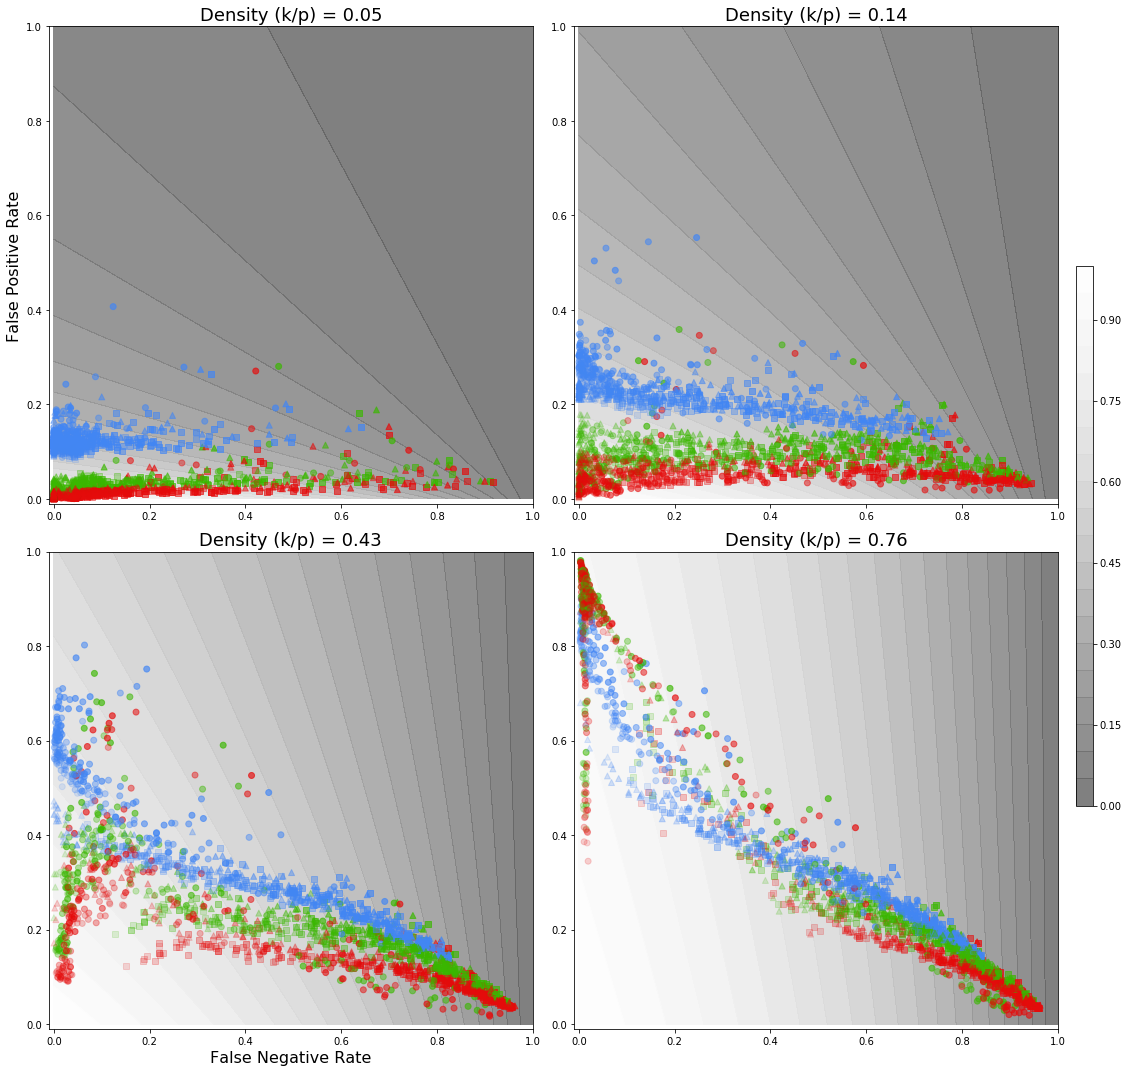

In [31]:
fig, ax = plt.subplots(2, 2, figsize = (15, 15))
scatters = []
n_features = 500
sparsity_ = [sparsity[3], sparsity[7], sparsity[11], sparsity[13]]
kappa_ = [5, 2, 1]
# Fix the number of samples!
np_ratio = 4
dframes = [lasso, mcp, scad]
selection_method = 'CV'

for i, s in enumerate(sparsity_):
    
    a = ax[np.unravel_index(i, (2, 2))]
    
    # Superimpose contours of constant selection accuracy
    xx = np.linspace(0, 1, 100)
    yy = np.linspace(0, 1, 100)
    z = np.zeros((100, 100))
    for ix, x in enumerate(xx):
        for iy, y in enumerate(yy):
            z[ix, iy] = 1 - ((1 - s)* y + s * x)/(s * (2 - x - y) + y) 
    
    cmap = plt.get_cmap('Greys_r')
    cmap_new = truncate_colormap(cmap, minval = 0.25)
    cs = a.contourf(xx, yy, z.T, 20, cmap = cmap_new, alpha = 0.75)

    # Set opacity via average correlation    
    for j, k in enumerate(kappa_):
        for ii, bw in enumerate([-1, np.inf, 0.1]):   
            for cidx, df in enumerate(dframes):
                fil_df = apply_df_filters(df, sparsity=s, selection_method = selection_method, 
                                                kappa = k, betawidth=bw, np_ratio=np_ratio)
                a, scat = FNR_FPR_scatter(a, fil_df, cols[cidx], marker = markers[ii])
        
    a.set_xlim([-0.01, 1])
    a.set_ylim([-0.01, 1])
    a.set_title('Density (k/p) = %.2f' % s, fontsize = 18)

ax[0, 0].set_ylabel('False Positive Rate', fontsize = 16)
ax[1, 0].set_xlabel('False Negative Rate', fontsize = 16)
cax = fig.add_axes([1, 0.25, 0.015, 0.5])
plt.colorbar(cs, cax = cax)
plt.tight_layout()
plt.savefig('fprvfnr_R2.pdf', bbox_inches = 'tight', pad_inches=0)

# Make a second version of the above plot with R^2. Also make the different betawidths different shaped points

In [ ]:
## ^ Interesting difference between betawidth -1 and the other ones

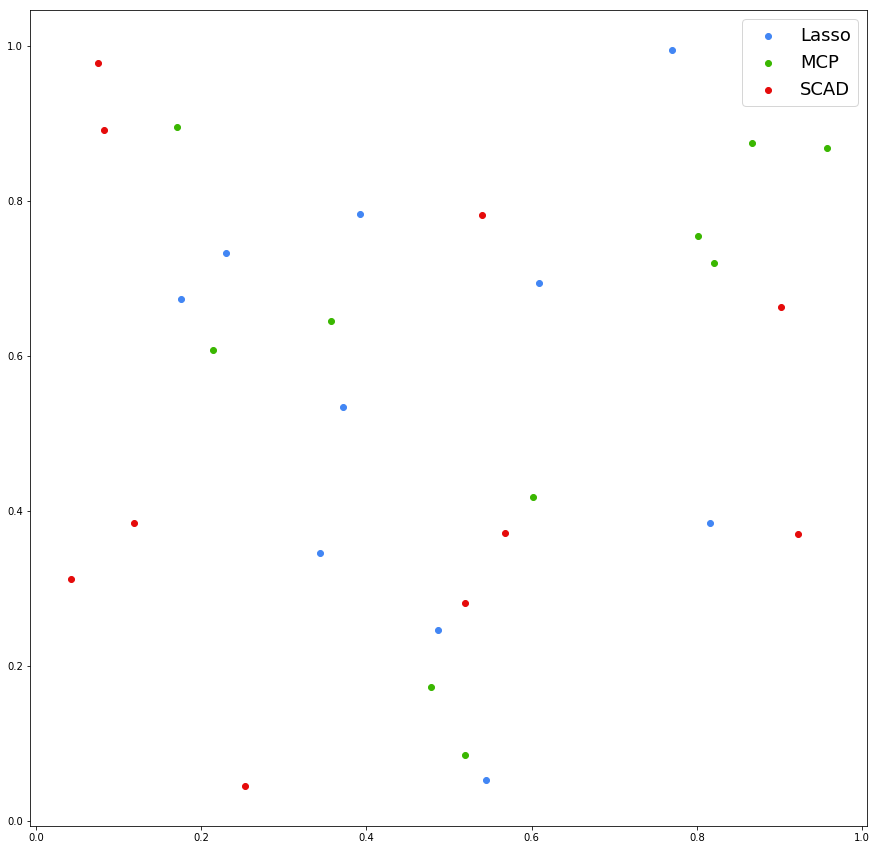

In [16]:
# Dummy plot to get a colormap
fig, ax = plt.subplots(figsize=(15, 15))
for cidx, df in enumerate(dframes):
    ax.scatter(np.random.random(10), np.random.random(10), c = cols[cidx])
plt.legend(['Lasso', 'MCP', 'SCAD'], fontsize=18)
plt.savefig('scatter_legend.pdf', bbox_inches='tight', pad_inches=0)

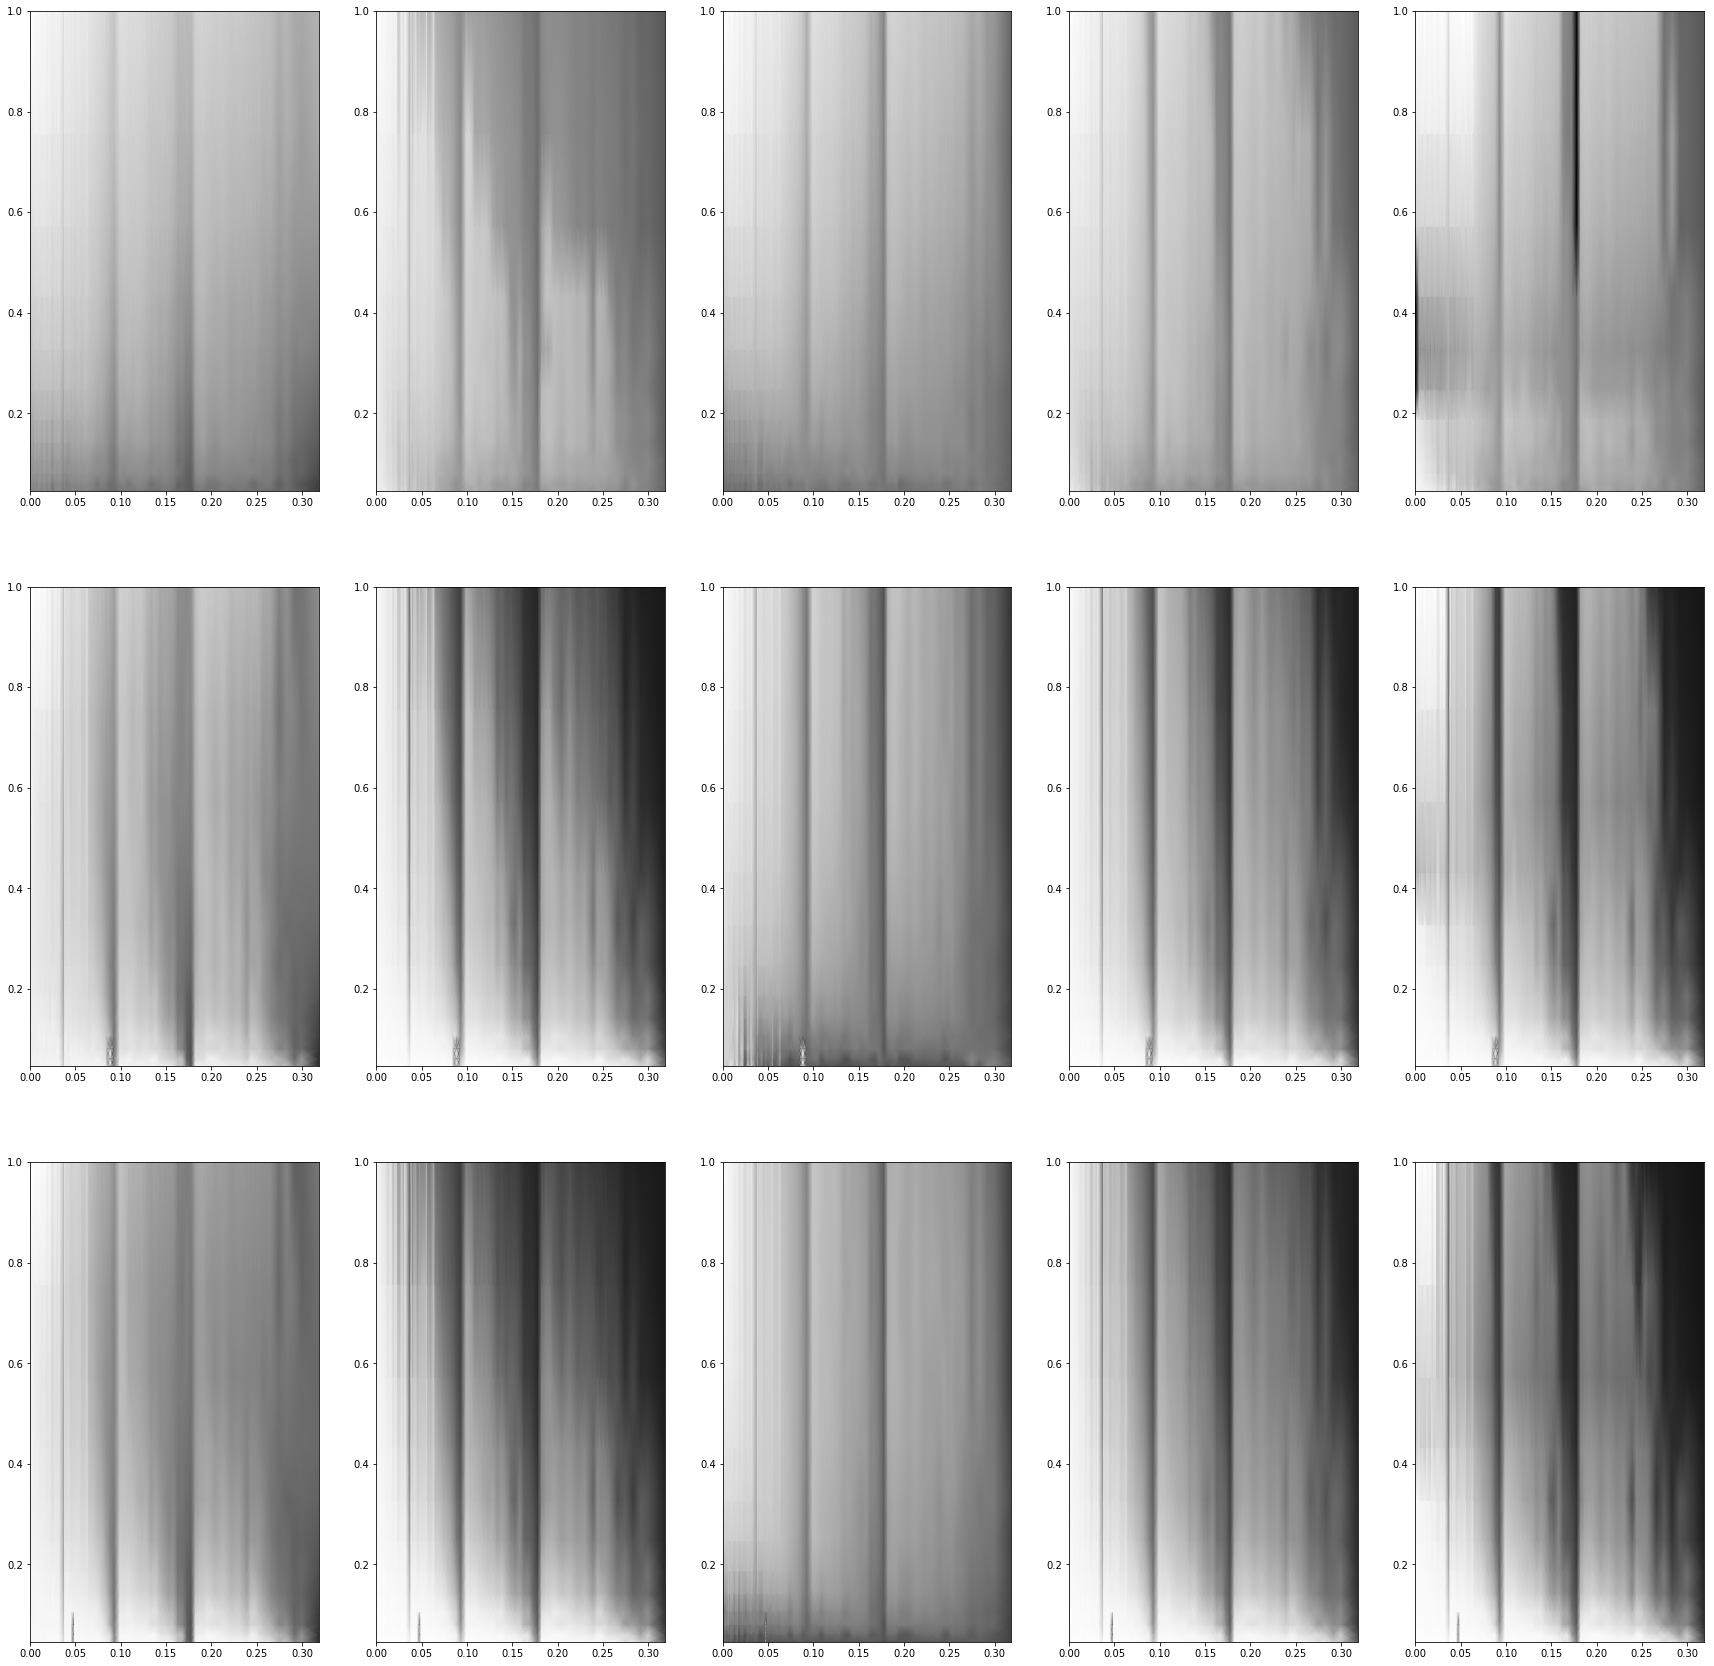

In [37]:
# 2D plots over sparsity vs. (average correlation, or can try spectral bounds) for SCAD, Lasso, UoI Lasso for the
# different model selction criteria

# Kind of a failure...

fig, ax = plt.subplots(3, 5, figsize = (30, 30))

dframes = [lasso, mcp, scad]
# Focus on a single n, SNR
kappa = 5
np_ratio = 4

selection_methods = ['CV', 'BIC', 'AIC', 'gMDL', 'empirical_bayes']

for i1, df in enumerate(dframes):
    for i2, sm in enumerate(selection_methods):
        df_ = apply_df_filters(df, selection_method=sm, kappa=kappa, np_ratio=np_ratio)
        sparsity_corr_2D(ax[i1, i2], df_, 'sa', False)

In [39]:
# List of cov_params 
cov_params, _ = group_dictionaries(df_[['correlation', 'block_size', 'L', 't']].to_dict('records'), None)

In [28]:
# Blue
c1 = ['#4286f4', '#99bdf7', '#00aeff']
# Green
c2 = ['#3ab700', '#bae288', '#64821d']
# Red
c3 = ['#e50b0b', '#ef5f5f', '#70001d']
# Cyan
c4 = ['#1ec9be', '#d799ff', '#572677']
# Orange
c5 = ['#e38f12']

cols = [c1[0], c2[0], c3[0], c4[0], c5[0], 'k']

In [26]:
# Linestyles
linestyles = ['solid', 'dashed', (0, (3, 1, 1, 1))] # densely dash dotted
# Marker styles
markers = ["o", "^", "s", "x", ">"]

selection_methods = ['BIC', 'AIC', 'CV', 'gMDL', 'empirical_bayes', 'oracle']

# Group information criteria together, CV as dashed, and adaptive as densley dash dotted
pltstyles = [('solid', "o"), ('solid', "^"), ('dashed', 's'), (linestyles[2], 'x'), (linestyles[2], ">")]


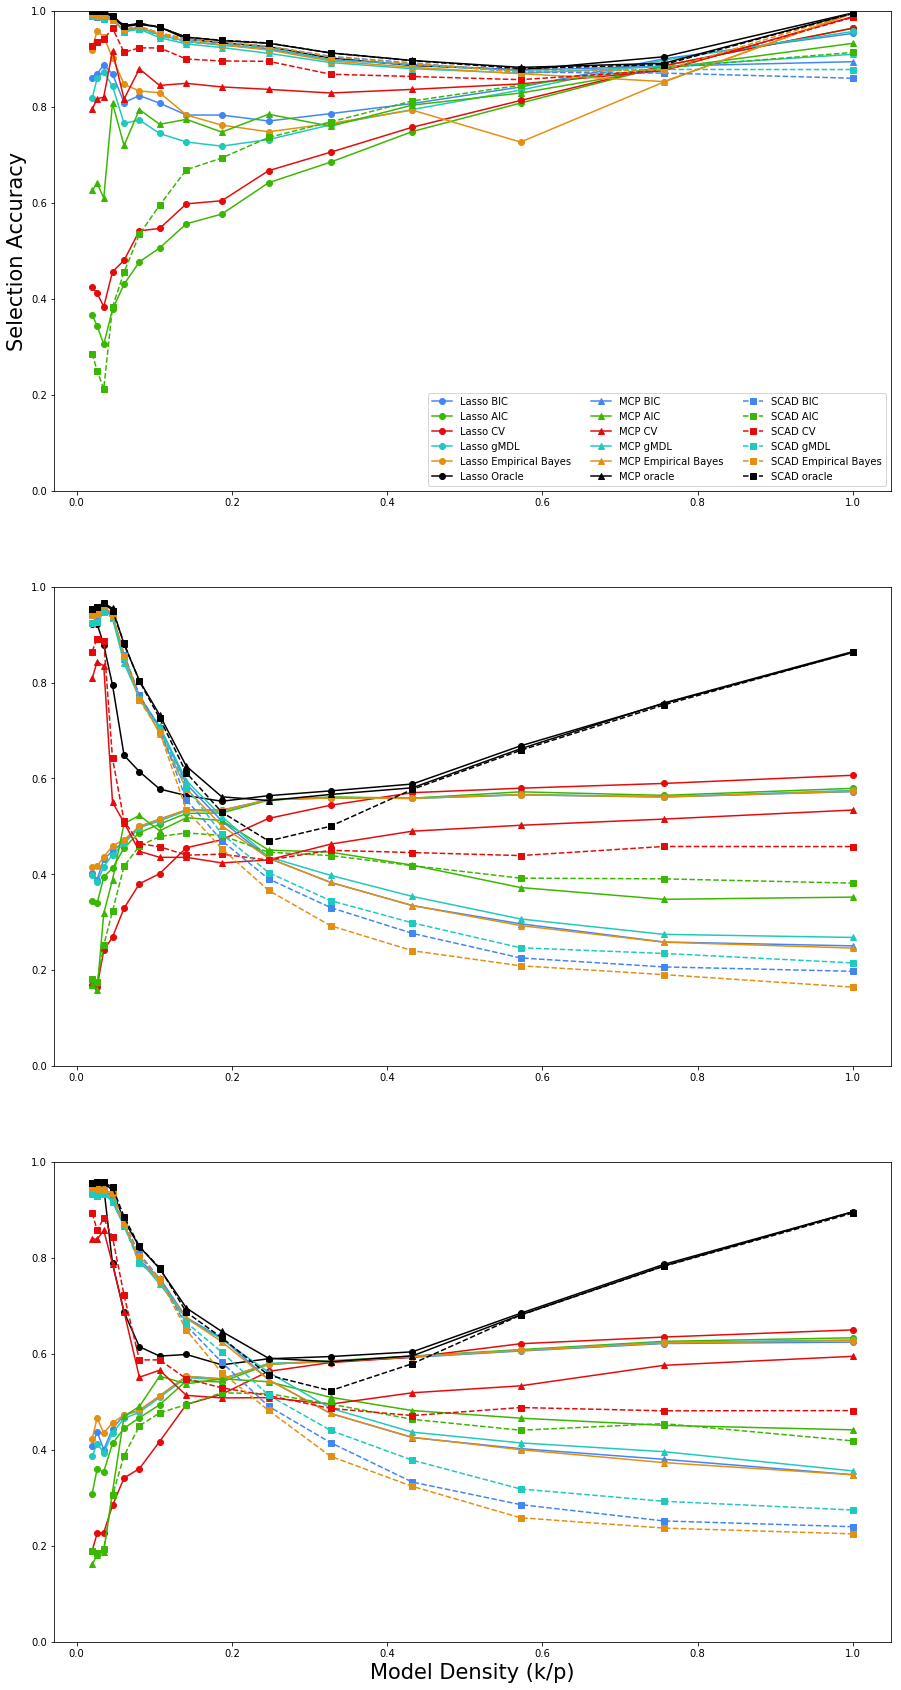

In [34]:
# For 3 different covariance matrices, plot selection accuracy vs sparsity for all algorithms and all selection methods
fig, ax = plt.subplots(3, 1, figsize = (15, 30))

# Manually selected cov_params
cov_params = [[0.15811388, 50.0, 1.0, 0.0], [0.0, 100.0, 100.0, 0.8897894862254017], [0.15811388, 50.0, 100.0, 0.7972883364187614]]

# Fix the np_ratio, signal to noise, and betawidth
np_ratio = 16
kappa = 5
betawidth = np.inf

sparsity = np.unique(lasso['sparsity'].values)
dframes = [lasso, mcp, scad]

# Use the same colors for each algorithm, different line style/marker combinations for each selection method
colors = []

for i1 in range(len(cov_params)):
    
    a = ax[i1]
    
    for i2, df in enumerate(dframes):
        
        df_ = apply_df_filters(df, np_ratio = np_ratio, 
                               correlation = cov_params[i1][0],
                               block_size = cov_params[i1][1],
                               L = cov_params[i1][2],
                               t = cov_params[i1][3],
                               kappa = kappa,
                               betawidth=betawidth)


        for i3, sm in enumerate(selection_methods):
    
            df_sm = apply_df_filters(df_, selection_method = sm)

            # Now average over the remaining degrees of freedom
            s, yvals, yerr = marginalize(df_sm, 'sa', ['sparsity'])
            
            # Extract and order
            s = np.array([val for sublist in s for val in sublist])
            yvals = yvals[0]
            yerr = yerr[0]
                        
            sorder = np.argsort(s)
            s = s[sorder]
            yvals = yvals[sorder]
            yerr = yerr[sorder]
            a.plot(s, yvals, marker = pltstyles[i2][1], linestyle = pltstyles[i2][0], color=cols[i3])
            a.set_ylim([0, 1])
            
ax[0].set_ylabel('Selection Accuracy', fontsize = 21)
ax[2].set_xlabel('Model Density (k/p)', fontsize = 21)
ax[0].legend(['Lasso BIC', 'Lasso AIC', 'Lasso CV', 'Lasso gMDL', 'Lasso Empirical Bayes', 'Lasso Oracle',
              'MCP BIC', 'MCP AIC', 'MCP CV', 'MCP gMDL', 'MCP Empirical Bayes', 'MCP oracle',
              'SCAD BIC', 'SCAD AIC', 'SCAD CV', 'SCAD gMDL', 'SCAD Empirical Bayes', 'SCAD oracle'], 
              ncol = 3, loc='lower right')
# plt.savefig('selection_method_comparisons.pdf', bbox_inches='tight', pad_inches=0)

In [8]:
from utils import gen_covariance

# Need to fix this guy LOL

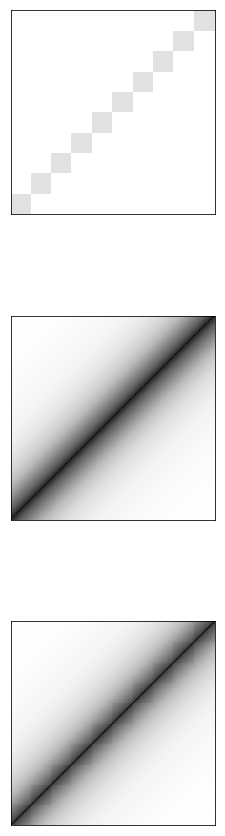

In [32]:
fig, ax = plt.subplots(3, 1, figsize = (7, 15))
cov_params = [[0.15811388, 50.0, 1.0, 0.0], [0.0, 100.0, 100.0, 0.8897894862254017], [0.15811388, 50.0, 100.0, 0.7972883364187614]]

for i in range(len(cov_params)): 
    
    block_size = int(cov_params[i][1])
    sigma = gen_covariance(500, cov_params[i][0], block_size, cov_params[i][2], cov_params[i][3]).T
    if i == 0:
        ax[i].pcolormesh(sigma.T, vmin = 0, vmax = 0.75, cmap = 'Greys')
    else:
        ax[i].pcolormesh(sigma.T, vmin = 0, vmax = 1, cmap = 'Greys')
    ax[i].set_aspect('equal')
    ax[i].set_xticks([])
    ax[i].set_yticks([])

plt.subplots_adjust(hspace = 0.5)
plt.savefig('cov_reference.pdf', bbox_inches='tight', pad_inches=0)

In [36]:
np_ratios = np.unique(lasso['np_ratio'].values)

In [45]:
from mpl_toolkits.mplot3d import Axes3D

In [63]:
%matplotlib notebook

In [66]:
np_ratios

array([ 2,  4,  6,  8, 16], dtype=int64)

In [74]:
np.unique(lasso['kappa'].values)

array([1, 2, 5], dtype=int64)

<IPython.core.display.Javascript object>


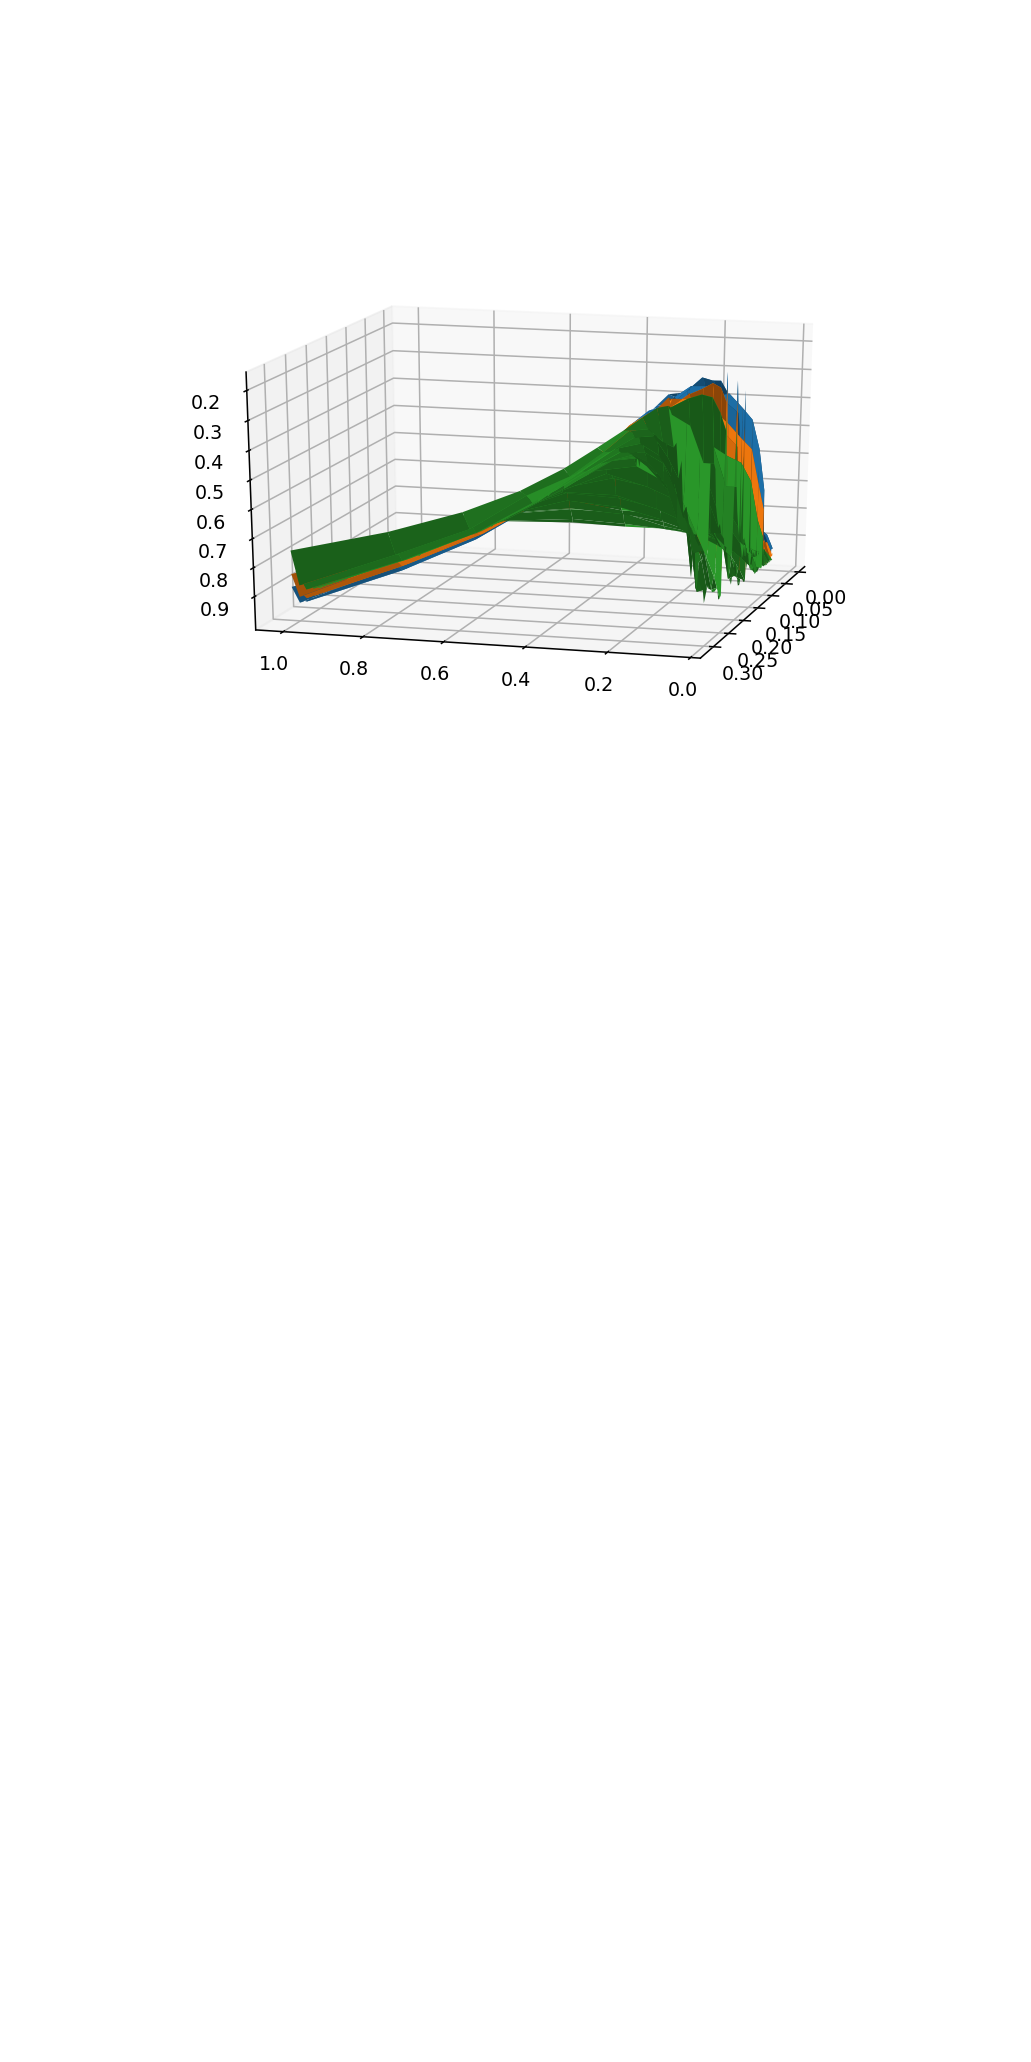

In [78]:
# Next plot type: Plot 2D surfaces of the oracle selection accuracy (achieved on at least 15/20 repetitions) for the different 
# n/p ratios vs. sparsity and average correlation

fig = plt.figure(figsize = (7.5, 15))

# Fix the signal to noise ratio for now 
np_ratio = 4

for i1, df in enumerate([lasso]):

    a = fig.add_subplot(3, 1, i1 + 1, projection='3d')
    for i2, kappa in enumerate([1, 2, 5]):
        df_ = apply_df_filters(df, kappa=kappa, np_ratio=np_ratio, betawidth=np.inf, selection_method='g')
        sparsity_corr_2D(a, df_, 'sa')

C:\Users\akumar\Anaconda3\envs\nse\lib\site-packages\matplotlib\figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


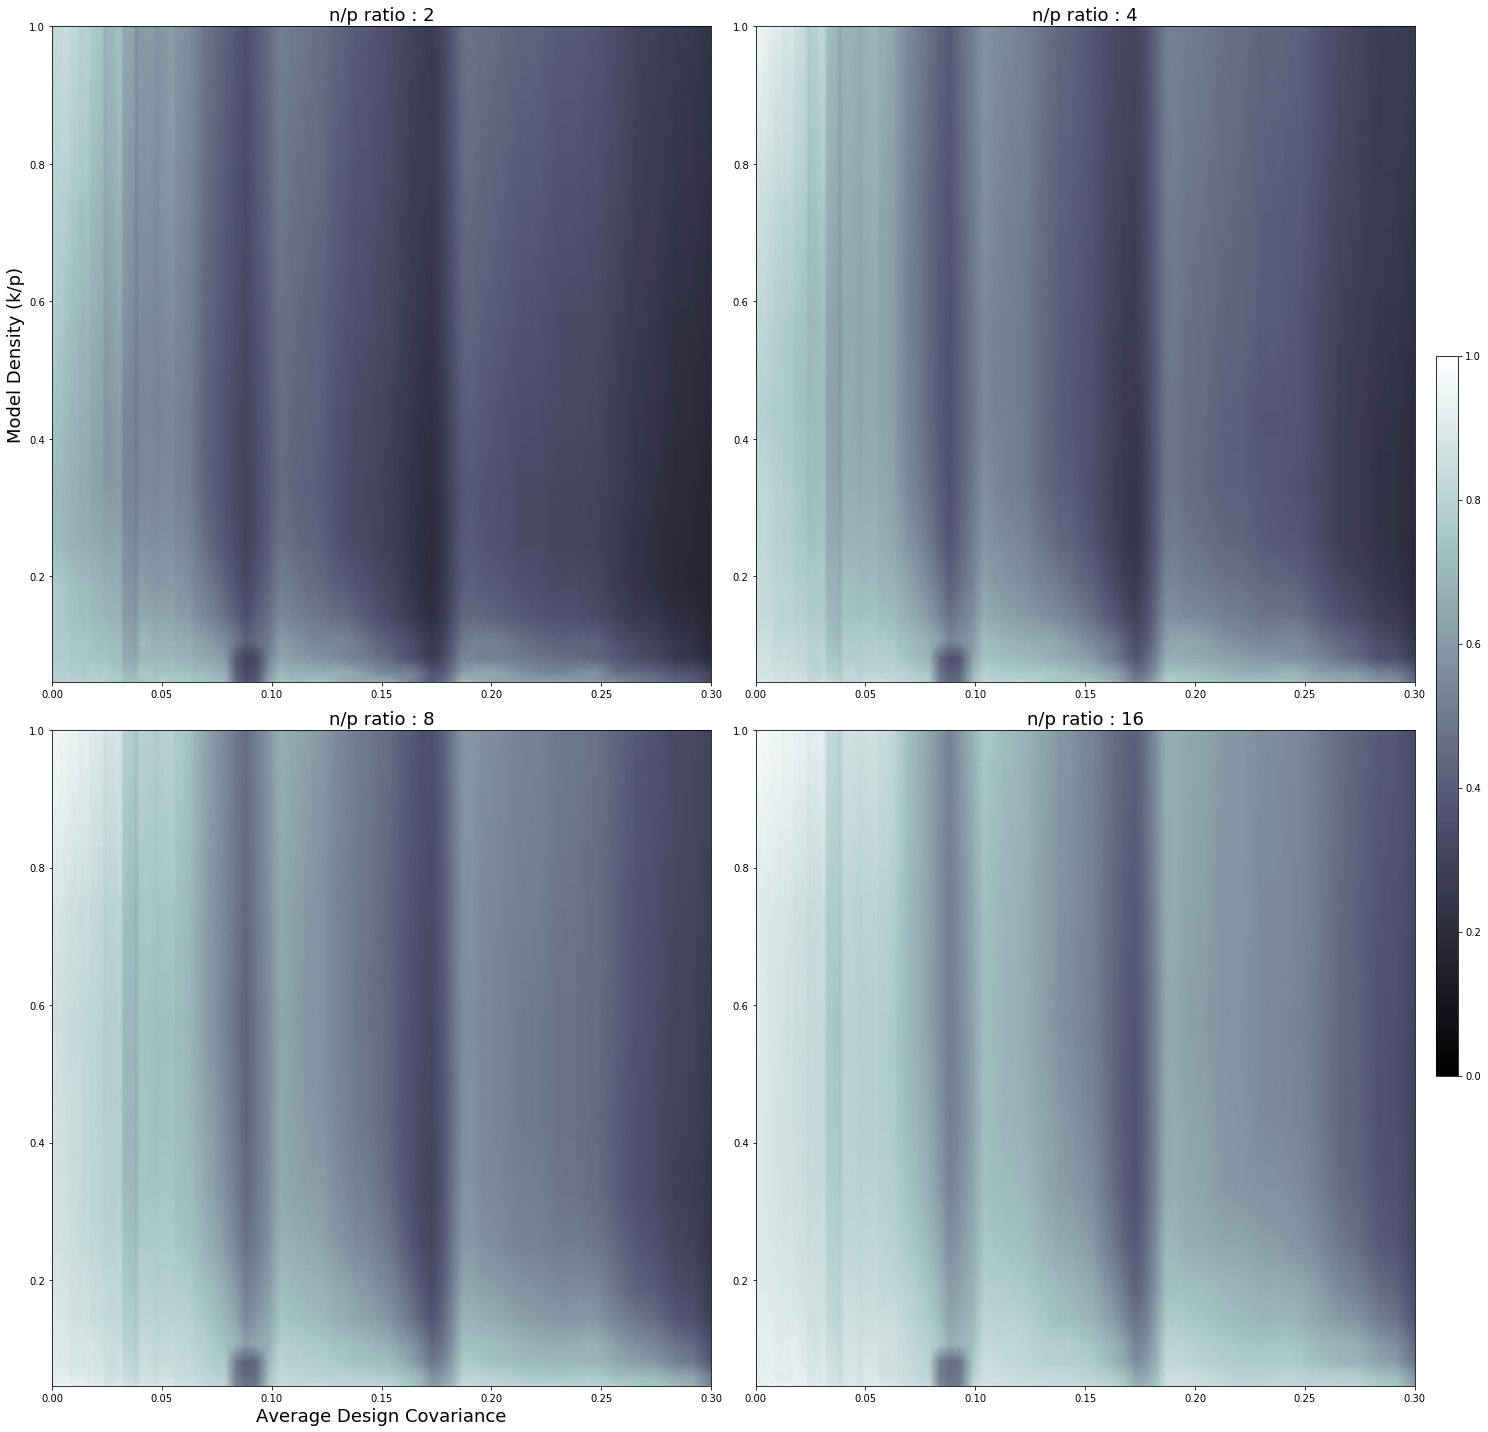

In [7]:
# Surfaces aren't really working out --> What we can do instead is to take the maximum (average) selection accuracy across all
# algorithms and plot colormaps as a function of sparsity and average correlation. Apply some smoothing to average correlation,
# and do some interpolation for sparsity. Then, plot these as panels for the the different n/p ratios OR signal to nosie, 
# depending on what exhibits greater variation

fig, ax = plt.subplots(2, 2, figsize = (20, 20))

for i1, np_ratio in enumerate([2, 4, 8, 16]):
    df = apply_df_filters(mcp, np_ratio = np_ratio, betawidth = np.inf, kappa = 5)
    h = sparsity_corr_2D_2(ax[np.unravel_index(i1, (2, 2))], df, 'sa')
    ax[np.unravel_index(i1, (2, 2))].set_title('n/p ratio : %d' % np_ratio, fontsize = 18)
    
ax[0, 0].set_ylabel('Model Density (k/p)', fontsize = 18)
ax[1, 0].set_xlabel('Average Design Covariance', fontsize = 18)
cax = fig.add_axes([1, 0.25, 0.015, 0.5])
plt.colorbar(h, cax = cax)
plt.tight_layout()
plt.savefig('n_scaling.pdf', bbox_inches='tight', pad_inches=0)

In [ ]:
# Estimation bias/variance
# Selection variance

In [10]:
import h5py

In [8]:
beta_hat_paths = ['/home/akumar/nse/data/sfn/lasso_beta_hat.h5',
                  '/home/akumar/nse/data/sfn/mcp_beta_hat.h5',
                  '/home/akumar/nse/data/sfn/scad_beta_hat.h5']


In [11]:
def calc_est_bias(dframe, beta_hat_path, beta_path):
    
    values_of_interest = dframe[['sparsity', 'L', 't', 'correlation', 'block_size']].to_dict('records')
    unique_values, rep_idxs = group_dictionaries(values_of_interest, None)
    
    est_bias = np.zeros(len(rep_idxs))
    
    with h5py.File(beta_hat_path, 'r') as f:
        with h5py.File(beta_path, 'r') as g:
            for j, rep_idx in enumerate(rep_idxs):
                df_ = dframe.iloc[rep_idx]
                row_indices = list(df_.index)

                # Convert row indices to 2D indices
                row_indices = np.unravel_index(row_indices, (f['beta_hat'].shape[0], f['beta_hat'].shape[1]))            

                # Load the corresponding rows of beta hat
                beta_hat = np.array([f['beta_hat'][row_indices[0][i], row_indices[1][i], :] 
                                     for i in range(row_indices[0].size)])

                beta = np.array([g['beta'][row_indices[0][i], row_indices[1][i], :] 
                                 for i in range(row_indices[0].size)])
                
                
                est_bias[j] = np.linalg.norm(np.mean(beta_hat - beta, axis = 0))

    return est_bias    

In [12]:
def calc_est_variance(dframe, beta_hat_path):
    
    values_of_interest = dframe[['sparsity', 'L', 't', 'correlation', 'block_size']].to_dict('records')
    unique_values, rep_idxs = group_dictionaries(values_of_interest, None)
    
    est_var = np.zeros(len(rep_idxs))
    
    with h5py.File(beta_hat_path) as f:
        
        for j, rep_idx in enumerate(rep_idxs):
            df_ = dframe.iloc[rep_idx]
            row_indices = list(df_.index)
            
            # Convert row indices to 2D indices
            row_indices = np.unravel_index(row_indices, (f['beta_hat'].shape[0], f['beta_hat'].shape[1]))            
            
            # Load the corresponding rows of beta hat
            beta_hat = np.array([f['beta_hat'][row_indices[0][i], row_indices[1][i], :] 
                                 for i in range(row_indices[0].size)])
            
            est_var[j] = np.mean(np.diag(np.cov(beta_hat.T)))
    return est_var    

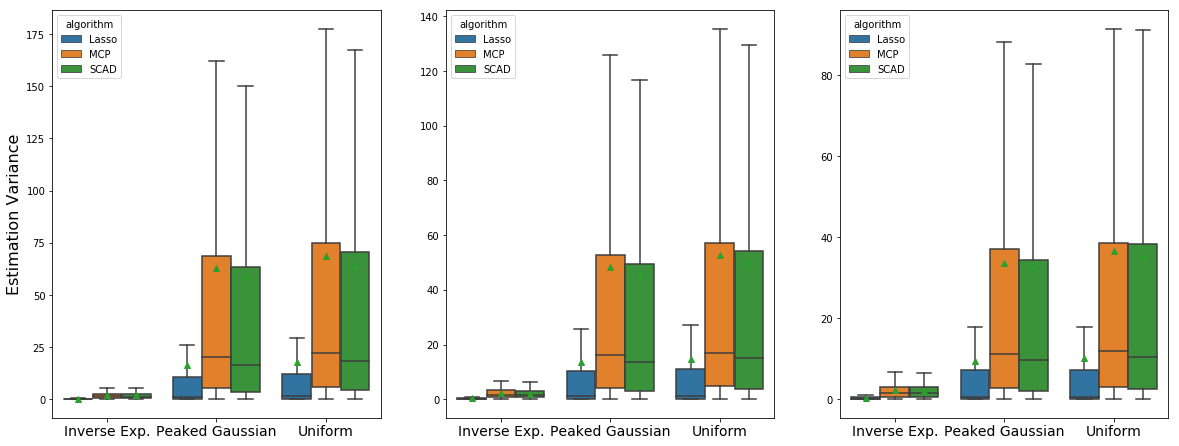

In [50]:
# Plot bar for the different algorithms, averaged over all instances

fig, ax = plt.subplots(1, 3, figsize = (20, 7.5))

# Calculate across signal to noise ratios, n/p ratio = 4
np_ratio = 4
kappa = np.unique(lasso['kappa'].values)
betawidth = np.unique(lasso['betawidth'].values)
selection_method = 'BIC'

dframes = [lasso, mcp, scad]
dframe_names = ['Lasso', 'MCP', 'SCAD']
beta_path = '/home/akumar/nse/data/sfn/sfn_beta.h5'

beta_hat_paths = ['/home/akumar/nse/data/sfn/lasso_beta_hat.h5',
                  '/home/akumar/nse/data/sfn/mcp_beta_hat.h5',
                  '/home/akumar/nse/data/sfn/scad_beta_hat.h5']

# Estimation variance 

# Select indices
for i1, k in enumerate(kappa):
    est_var = []
    for i2, bw in enumerate(betawidth):
        for i3, dframe in enumerate(dframes):
            df = apply_df_filters(dframe, kappa=k, np_ratio=np_ratio, 
                                  betawidth=bw, selection_method=selection_method)
            # Calculate variances across reps
            values = calc_est_variance(df, beta_hat_paths[i3])
            dat_list = [[dframe_names[i3], bw, value] for value in values]
            est_var.extend(dat_list)

    # Create new dataframe for plotting
    plt_df = pd.DataFrame(est_var, columns=['algorithm', 'betawidth', 'est_var'])
    sns.boxplot(x='betawidth', y ='est_var', hue='algorithm', data=plt_df, ax = ax[i1],
                showmeans=True, showfliers=False)
    ax[i1].set_xlabel('')
    ax[i1].set_ylabel('')
    ax[i1].set_xticklabels(['Inverse Exp.', 'Peaked Gaussian', 'Uniform'], fontsize = 14)

ax[0].set_ylabel('Estimation Variance', fontsize = 16)
plt.savefig('estvar.pdf', bbox_inches='tight', pad_inches=0)

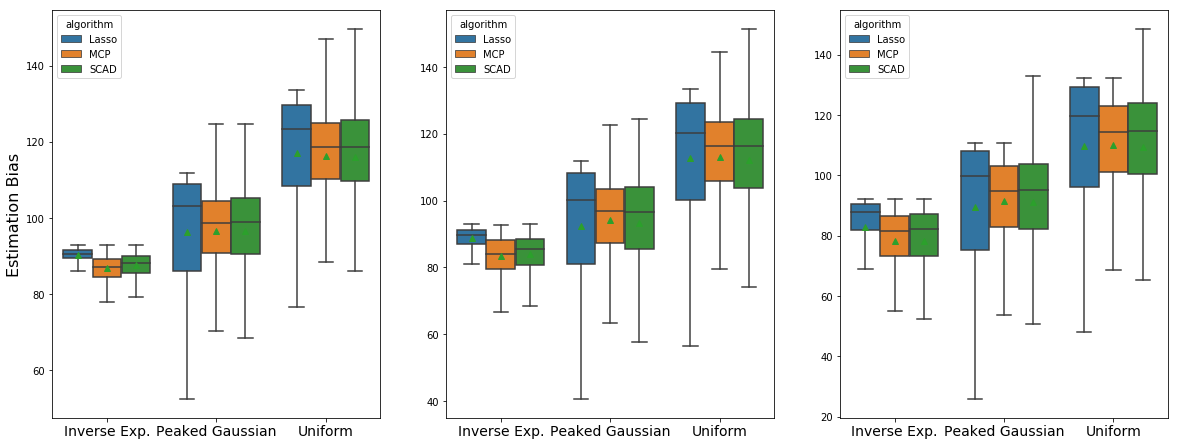

In [74]:
# Plot bar for the different algorithms, averaged over all instances

fig, ax = plt.subplots(1, 3, figsize = (20, 7.5))

# Calculate across signal to noise ratios, n/p ratio = 4
np_ratio = 4
kappa = np.unique(lasso['kappa'].values)
betawidth = np.unique(lasso['betawidth'].values)
selection_method = 'BIC'

dframes = [lasso, mcp, scad]
dframe_names = ['Lasso', 'MCP', 'SCAD']
beta_path = ['/home/akumar/nse/data/sfn/lasso2_beta.h5',
             '/home/akumar/nse/data/sfn/mcp2_beta.h5',
             '/home/akumar/nse/data/sfn/scad2_beta.h5']

beta_hat_paths = ['/home/akumar/nse/data/sfn/lasso_beta_hat.h5',
                  '/home/akumar/nse/data/sfn/mcp_beta_hat.h5',
                  '/home/akumar/nse/data/sfn/scad_beta_hat.h5']

# Estimation variance 

# Select indices
for i1, k in enumerate(kappa):
    est_var = []
    for i2, bw in enumerate(betawidth):
        for i3, dframe in enumerate(dframes):
            df = apply_df_filters(dframe, kappa=k, np_ratio=np_ratio, 
                                  betawidth=bw, selection_method=selection_method)
            # Calculate variances across reps
            values = calc_est_bias(df, beta_hat_paths[i3], beta_path[i3])
            dat_list = [[dframe_names[i3], bw, value] for value in values]
            est_var.extend(dat_list)

    # Create new dataframe for plotting
    plt_df = pd.DataFrame(est_var, columns=['algorithm', 'betawidth', 'est_var'])
    sns.boxplot(x='betawidth', y ='est_var', hue='algorithm', data=plt_df, ax = ax[i1],
                showmeans=True, showfliers=False)
    ax[i1].set_xlabel('')
    ax[i1].set_ylabel('')
    ax[i1].set_xticklabels(['Inverse Exp.', 'Peaked Gaussian', 'Uniform'], fontsize = 14)

ax[0].set_ylabel('Estimation Bias', fontsize = 16)


# Estimation variance 

# Select indices
for i1, k in enumerate(kappa):
    est_var = []
    for i2, bw in enumerate(betawidth):
        for i3, dframe in enumerate(dframes):
            df = apply_df_filters(dframe, kappa=k, np_ratio=np_ratio, 
                                  betawidth=bw, selection_method=selection_method)
            # Calculate variances across reps
            values = calc_est_variance(df, beta_hat_paths[i3])
            dat_list = [[dframe_names[i3], bw, value] for value in values]
            est_var.extend(dat_list)

    # Create new dataframe for plotting
    plt_df = pd.DataFrame(est_var, columns=['algorithm', 'betawidth', 'est_var'])
    sns.boxplot(x='betawidth', y ='est_var', hue='algorithm', data=plt_df, ax = ax[i1],
                showmeans=True, showfliers=False)
    ax[i1].set_xlabel('')
    ax[i1].set_ylabel('')
    ax[i1].set_xticklabels(['Inverse Exp.', 'Peaked Gaussian', 'Uniform'], fontsize = 14)

ax[0].set_ylabel('Estimation Variance', fontsize = 16)



plt.savefig('estbias.pdf', bbox_inches='tight', pad_inches=0)

TypeError: Argument sequence too long

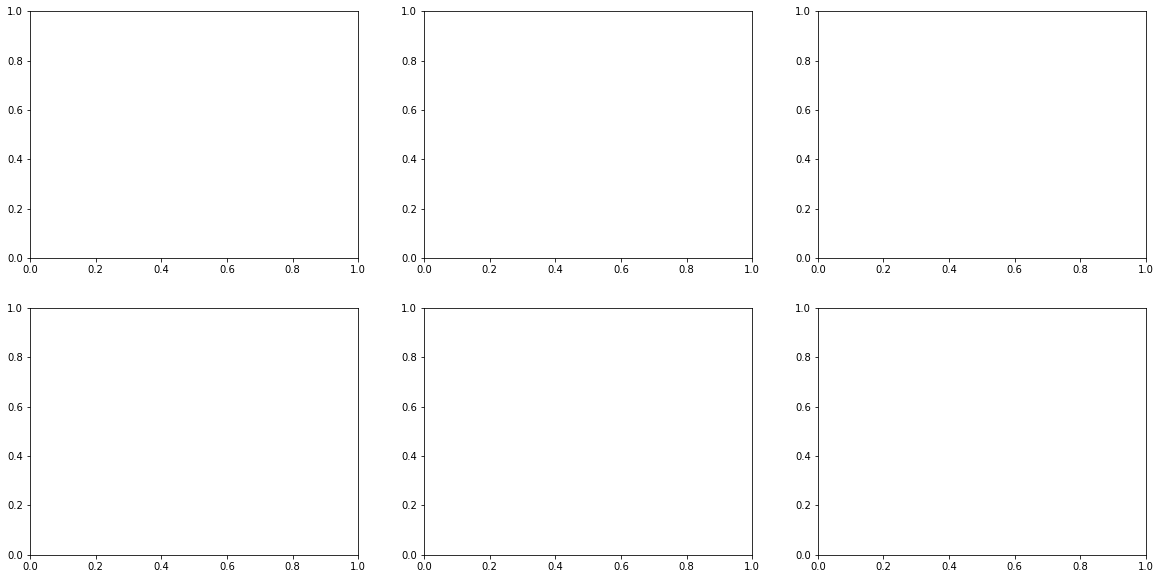

In [14]:
# Combine both plots into a single one

# Plot bar for the different algorithms, averaged over all instances

fig, ax = plt.subplots(2, 3, figsize = (20, 10))

# Calculate across signal to noise ratios, n/p ratio = 4
np_ratio = 4
kappa = np.unique(lasso['kappa'].values)
betawidth = np.unique(lasso['betawidth'].values)
selection_method = 'BIC'

dframes = [lasso, mcp, scad, uoi, en]
dframe_names = ['Lasso', 'MCP', 'SCAD']
beta_path = ['/home/akumar/nse/data/sfn/lasso2_beta.h5',
             '/home/akumar/nse/data/sfn/mcp2_beta.h5',
             '/home/akumar/nse/data/sfn/scad2_beta.h5',
            './uoi_beta.h5',
            './en_beta.h5']

beta_hat_paths = ['/home/akumar/nse/data/sfn/lasso_beta_hat.h5',
                  '/home/akumar/nse/data/sfn/mcp_beta_hat.h5',
                  '/home/akumar/nse/data/sfn/scad_beta_hat.h5',
                  './uoi_beta_hat.h5',
                  './en_beta_hat.h5']

# Estimation Bias

# Select indices
for i1, k in enumerate([5]):
    est_var = []
    for i2, bw in enumerate(betawidth):
        for i3, dframe in enumerate(dframes):
            df = apply_df_filters(dframe, kappa=k, np_ratio=np_ratio, 
                                  betawidth=bw, selection_method=selection_method)
            # Calculate variances across reps
            values = calc_est_bias(df, beta_hat_paths[i3], beta_path[i3])
            dat_list = [[dframe_names[i3], bw, value] for value in values]
            est_var.extend(dat_list)

    # Create new dataframe for plotting
    plt_df = pd.DataFrame(est_var, columns=['algorithm', 'betawidth', 'est_var'])
    bpl = sns.boxplot(x='betawidth', y ='est_var', hue='algorithm', data=plt_df, ax = ax[0, i1],
                showmeans=True, showfliers=False)
    bpl.legend_.remove()
    ax[0, i1].set_xlabel('')
    ax[0, i1].set_ylabel('')
    ax[0, i1].set_xticklabels([])
ax[0, 0].set_ylabel('Estimation Bias', fontsize = 18)

# Estimation variance 

# Select indices
for i1, k in enumerate(kappa):
    est_var = []
    for i2, bw in enumerate(betawidth):
        for i3, dframe in enumerate(dframes):
            df = apply_df_filters(dframe, kappa=k, np_ratio=np_ratio, 
                                  betawidth=bw, selection_method=selection_method)
            # Calculate variances across reps
            values = calc_est_variance(df, beta_hat_paths[i3])
            dat_list = [[dframe_names[i3], bw, value] for value in values]
            est_var.extend(dat_list)

    # Create new dataframe for plotting
    plt_df = pd.DataFrame(est_var, columns=['algorithm', 'betawidth', 'est_var'])
    bpl = sns.boxplot(x='betawidth', y ='est_var', hue='algorithm', data=plt_df, ax = ax[1, i1],
                showmeans=True, showfliers=False)
    bpl.legend_.remove()
    ax[1, i1].set_xlabel('')
    ax[1, i1].set_ylabel('')
    ax[1, i1].set_xticklabels(['Inverse Exp.', 'Peaked Gaussian', 'Uniform'], fontsize = 14)

ax[1, 0].set_ylabel('Estimation Variance', fontsize = 18)
plt.savefig('est.pdf', bbox_inches='tight', pad_inches=0)